In [1]:
import pandas as pd
import time
from tensorflow.keras.utils import to_categorical
import numpy as np
import random
import zipfile
import os
import shutil
from google.colab import files
import librosa                            # Параметризация аудио
import librosa.display                    # Визуализация аудио
import matplotlib.pyplot as plt           # Отрисовка графиков
import IPython.display as ipd             # Проигрывание аудио в colab
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Нормирование сигнала
from sklearn.preprocessing import minmax_scale, scale

%matplotlib inline

In [2]:
def handle_outliers_in_csv(collection, base_path):
    csv_path = os.path.join(base_path, f"{collection}.csv")

    expected_fields = {
        'Headliner': 72,
        'Primavera': 74,
        'Paveletskaya': 74
    }.get(collection, 74)  # default to 74 fields

    with open(csv_path, 'r') as data:
        corrected_data = []
        corrections_made = False
        modified_lines = 0
        for n, string in enumerate(data):
            list_string = string.split(';')
            if len(list_string) > expected_fields:
                corrections_made = True
                modified_lines += 1
                print(f"Линия {n + 1}: Найдено {len(list_string)} колонок. Ожидалось {expected_fields}.")
                list_string = list_string[:expected_fields]
                corrected_data.append(';'.join(list_string))
            else:
                corrected_data.append(string.rstrip())

    if corrections_made:
        corrected_csv_path = os.path.join(base_path, f"{collection}_without_outlier.csv")
        with open(corrected_csv_path, 'w') as new_data:
            new_data.write('\n'.join(corrected_data))
        print(f"Общее количество линий модифицировано для {collection}: {modified_lines}")

In [3]:
handle_outliers_in_csv("Headliner", "/content/drive/MyDrive/Phone_calls/V2")

Линия 83: Найдено 76 колонок. Ожидалось 72.
Линия 432: Найдено 76 колонок. Ожидалось 72.
Линия 618: Найдено 76 колонок. Ожидалось 72.
Линия 1766: Найдено 76 колонок. Ожидалось 72.
Линия 1779: Найдено 76 колонок. Ожидалось 72.
Линия 2106: Найдено 76 колонок. Ожидалось 72.
Линия 4601: Найдено 76 колонок. Ожидалось 72.
Общее количество линий модифицировано для Headliner: 7


In [ ]:
handle_outliers_in_csv("Primavera", "/content/drive/MyDrive/Phone_calls/V2")

In [5]:
handle_outliers_in_csv("Paveletskaya", "/content/drive/MyDrive/Phone_calls/V2")

Линия 14: Найдено 76 колонок. Ожидалось 74.
Линия 17: Найдено 82 колонок. Ожидалось 74.
Линия 156: Найдено 76 колонок. Ожидалось 74.
Линия 428: Найдено 78 колонок. Ожидалось 74.
Линия 669: Найдено 76 колонок. Ожидалось 74.
Линия 735: Найдено 78 колонок. Ожидалось 74.
Линия 3399: Найдено 76 колонок. Ожидалось 74.
Линия 5177: Найдено 78 колонок. Ожидалось 74.
Линия 5179: Найдено 78 колонок. Ожидалось 74.
Общее количество линий модифицировано для Paveletskaya: 9


In [64]:
def process_collection_with_patterns(collection, patterns, base_path):

    for pattern in patterns:

        csv_path = os.path.join(base_path, f"{collection}_without_outlier.csv")
        zip_path = os.path.join(base_path, f"{collection}.zip")
        extract_folder = os.path.join(base_path, f"filtered_files_{pattern}_{collection}")
        dest_dir = os.path.join(base_path, 'data', pattern_to_folder(pattern))

        if not os.path.exists(extract_folder):
            os.makedirs(extract_folder)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)

        df = pd.read_csv(csv_path, delimiter=';', on_bad_lines='warn')
        filtered_df = df[df["Теги"].str.contains(pattern, na=False, regex=True)]
        result_df = filtered_df[["Теги", "Идентификатор сессии звонка"]]
        result_csv_path = os.path.join(base_path, f"Filtered_tags_{pattern}_{collection}.csv")
        result_df.to_csv(result_csv_path, index=False)

        identifiers = filtered_df['Идентификатор сессии звонка'].tolist()

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            matched_files = 0
            missing_identifiers = []
            for identifier in identifiers:
                matched = False
                for file in zip_ref.namelist():
                    if str(identifier) in file:
                        zip_ref.extract(file, extract_folder)
                        os.rename(os.path.join(extract_folder, file), os.path.join(extract_folder, f"{identifier}.mp3"))
                        matched = True
                        matched_files += 1
                        break
                if not matched:
                    missing_identifiers.append(identifier)

            print(f"Коллекция: {collection}, Pattern: {pattern}")
            print(f"Общее количество совпадений: {matched_files}")
            print(f"Ненайдено аудио записей: общее: {len(missing_identifiers)} и список: {missing_identifiers}")

        copy_mp3_files(extract_folder, dest_dir)
        total_files = len([f for f in os.listdir(dest_dir) if os.path.isfile(os.path.join(dest_dir, f))])
        print(f"Общее количество файлов в {dest_dir}: {total_files}")

def copy_mp3_files(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        if filename.endswith('.mp3'):
            shutil.copy(os.path.join(src_dir, filename), dest_dir)

def pattern_to_folder(pattern):
    mapping = {
        'Нецелевой контакт': 'nontargets',
        'Первичный целевой': 'targets',
        'Вторичный целевой': 'secondarytargets',
        'Нецелевой звонок': 'nontargets',
        'Целевой_М108': 'targets',
        'Повтор_М108': 'secondarytargets',
        'Нецелевой контакт_М108': 'nontargets'
    }
    return mapping.get(pattern, 'unknown')

In [ ]:
process_collection_with_patterns('Headliner', ['Нецелевой звонок', 'Первичный целевой', 'Вторичный целевой'], '/content/drive/MyDrive/Phone_calls/V2')

In [ ]:
process_collection_with_patterns('Primavera', ['Целевой_М108', 'Повтор_М108', 'Нецелевой контакт_М108'], '/content/drive/MyDrive/Phone_calls/V2')

In [ ]:
process_collection_with_patterns('Paveletskaya', ['Целевой_М108', 'Повтор_М108', 'Нецелевой контакт'], '/content/drive/MyDrive/Phone_calls/V2')

In [10]:
classes = ['nontargets', 'secondarytargets', 'targets']
for eachclass in classes:
  total_files = len([f for f in os.listdir(f'/content/drive/MyDrive/Phone_calls/V2/data/{eachclass}') if os.path.isfile(os.path.join(f'/content/drive/MyDrive/Phone_calls/V2/data/{eachclass}', f))])
  print(f"Общее количество файлов в классе {eachclass}: {total_files}")

Общее количество файлов в классе nontargets: 919
Общее количество файлов в классе secondarytargets: 630
Общее количество файлов в классе targets: 1307


In [11]:
# Функция загрузки аудио и вывода текстовой информации
# о сигнале, а также проигрывателя аудио

def load_audio(audio_path,       # путь к файлу с аудио
               show_text=True,   # показывать ли текстовую сводку по аудио
               show_player=True  # выводить ли проигрыватель в ячейку
               ):
    # Загрузка аудиофайла, на выходе:
    # x  - массив данных временного ряда аудио
    # sr - частота дискретизации временного ряда
    x, sr = librosa.load(audio_path)

    if show_text:
        # Вывод текстовых данных о сигнале
        print(f'Типы данных x и sr: {type(x)}, {type(sr)}')
        print(f'Форма данных x: {x.shape}, sr = {sr}')
        print('Продолжительность сигнала:', round(x.shape[0]/sr), 'с.\n')

    if show_player:
        # Вывод проигрывателя в ячейку colab
        ipd.display(ipd.Audio(audio_path))

    # Возврат загруженных данных для дальнейшего использования
    return x, sr

In [12]:
directory_path = '/content/drive/MyDrive/Phone_calls/V2/data/targets'
counter = 0
for filename in os.listdir(directory_path):
    if filename.endswith('.mp3'):
        file_path = os.path.join(directory_path, filename)
        x, sr = load_audio(file_path, show_text=False, show_player=False)
        duration = len(x) / sr
        if duration < 75:
            os.remove(file_path)
            # print(f"Deleted {filename} due to short duration.")
            counter += 1
print(f'Файлов удалено: {counter}')

Файлов удалено: 103


In [32]:
classes = ['nontargets', 'secondarytargets', 'targets']
for eachclass in classes:
  total_files = len([f for f in os.listdir(f'/content/drive/MyDrive/Phone_calls/V2/data/{eachclass}') if os.path.isfile(os.path.join(f'/content/drive/MyDrive/Phone_calls/V2/data/{eachclass}', f))])
  print(f"Общее количество файлов в классе {eachclass}: {total_files}")

Общее количество файлов в классе nontargets: 919
Общее количество файлов в классе secondarytargets: 630
Общее количество файлов в классе targets: 1204


In [33]:
def copy_random_files(base_path, class_name, target_count):
    class_folder = os.path.join(base_path, 'data', class_name)
    new_folder = os.path.join(base_path, 'subset_data', f"{class_name}")

    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    file_list = [f for f in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, f))]

    selected_files = random.sample(file_list, target_count)

    for filename in selected_files:
        source = os.path.join(class_folder, filename)
        destination = os.path.join(new_folder, filename)
        shutil.copy2(source, destination)

    print(f"Скопировано {target_count} рандомных файлов из {class_folder} в {new_folder}.")
    print(f"Общее количество файлов в {new_folder}: {len(os.listdir(new_folder))}")

In [34]:
base_path = '/content/drive/MyDrive/Phone_calls/V2'
target_count = 630

copy_random_files(base_path, 'nontargets', target_count)
copy_random_files(base_path, 'targets', target_count)
copy_random_files(base_path, 'secondarytargets', target_count)

Скопировано 630 рандомных файлов из /content/drive/MyDrive/Phone_calls/V2/data/nontargets в /content/drive/MyDrive/Phone_calls/V2/subset_data/nontargets.
Общее количество файлов в /content/drive/MyDrive/Phone_calls/V2/subset_data/nontargets: 630
Скопировано 630 рандомных файлов из /content/drive/MyDrive/Phone_calls/V2/data/targets в /content/drive/MyDrive/Phone_calls/V2/subset_data/targets.
Общее количество файлов в /content/drive/MyDrive/Phone_calls/V2/subset_data/targets: 630
Скопировано 630 рандомных файлов из /content/drive/MyDrive/Phone_calls/V2/data/secondarytargets в /content/drive/MyDrive/Phone_calls/V2/subset_data/secondarytargets.
Общее количество файлов в /content/drive/MyDrive/Phone_calls/V2/subset_data/secondarytargets: 630


In [35]:
nontargets_data = os.listdir('/content/drive/MyDrive/Phone_calls/V2/subset_data/nontargets')
secondtargets_data = os.listdir('/content/drive/MyDrive/Phone_calls/V2/subset_data/secondarytargets')
targets_data = os.listdir('/content/drive/MyDrive/Phone_calls/V2/subset_data/targets')
print(f'nontargets length: {len(nontargets_data)}')
print(f'secondtargets length: {len(secondtargets_data)}')
print(f'targets length: {len(targets_data)}')

nontargets length: 630
secondtargets length: 630
targets length: 630


In [46]:
FILE_DIR = '/content/drive/MyDrive/Phone_calls/V2/subset_data'
CLASS_LIST = os.listdir(FILE_DIR)
CLASS_LIST.sort()
CLASS_COUNT = len(CLASS_LIST)
CLASS_FILES = 630                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 565               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 200                         # Анализируемая длительность аудиосигнала
N_FFT = 4096                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [37]:
print(CLASS_LIST)

['nontargets', 'secondarytargets', 'targets']


In [38]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Сборка параметров в общий список:
    # На один файл один усредненный вектор признаков
    features = {'rmse': rmse.mean(axis=1, keepdims=True),
                'spct': spec_cent.mean(axis=1, keepdims=True),
                'spbw': spec_bw.mean(axis=1, keepdims=True),
                'roff': rolloff.mean(axis=1, keepdims=True),
                'zcr' : zcr.mean(axis=1, keepdims=True),
                'mfcc': mfcc.mean(axis=1, keepdims=True),
                'stft': chroma_stft.mean(axis=1, keepdims=True)}

    return features

In [39]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [40]:
# Проверка параметризации одного произведения
y, sr = librosa.load(f'{FILE_DIR}/targets/2906114070.mp3', mono=True, duration=DURATION_SEC)
features = get_features(y, sr)

In [41]:
print({k: v.shape for k, v in features.items()})

{'rmse': (1, 1), 'spct': (1, 1), 'spbw': (1, 1), 'roff': (1, 1), 'zcr': (1, 1), 'mfcc': (20, 1), 'stft': (12, 1)}


In [42]:
# Проверка формирования набора признаков
feature_set = stack_features(features)
feature_set.shape

(1, 37)

In [43]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [48]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    if class_name == "nontargets":
        file_name = nontargets_data[file_index]
    elif class_name == "secondarytargets":
        file_name = secondtargets_data[file_index]
    elif class_name == "targets":
        file_name = targets_data[file_index]
    else:
        raise ValueError(f"Unknown class name: {class_name}")
    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{file_name}'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index,
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [45]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])
            # print(f'Жанр {CLASS_LIST[class_index]} - файл {file_index} готов -> {round(time.time() - curr_time)} c')

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [49]:
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

Жанр nontargets готов -> 642 c
Жанр secondarytargets готов -> 2302 c
Жанр targets готов -> 3673 c


In [52]:
import pickle
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('/content/drive/MyDrive/Phone_calls/V2/model_data/audio_data_mean.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

In [53]:
with open('/content/drive/MyDrive/Phone_calls/V2/model_data/audio_data_mean.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [54]:
print(np.argmax(y_train_data[560:1166], axis=1))

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [55]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(1695, 37) float32
(1695, 3) float32


In [56]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [57]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [58]:
# Проверка нормирования
print(x_train[0])

[-8.0107582e-01  2.2164457e-01 -5.9256079e-03  2.0580964e-01
  7.0900291e-02  1.1191319e-03 -4.3521941e-01  9.6331723e-02
  1.3540144e-01  2.4845549e-01 -3.2656219e-02 -1.2218077e+00
 -1.8886469e-01  6.7105478e-01 -5.3534007e-01 -5.1117611e-01
  1.0173414e-02 -5.7571745e-01  3.7308463e-01  6.2786281e-01
 -1.2761772e+00 -1.2474687e+00  5.4949719e-01 -8.5104120e-01
 -1.5963324e+00 -1.6201641e-01  1.3393575e-01 -1.1609055e-01
 -2.3702140e-01 -3.7720200e-01 -4.3613598e-01 -1.5213500e-01
 -5.0001949e-02  8.6536385e-02  9.4480537e-02 -1.1450902e-01
 -1.2998492e-01]


In [59]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(1525, 37) float32
(1525, 3) float32

(170, 37) float32
(170, 3) float32


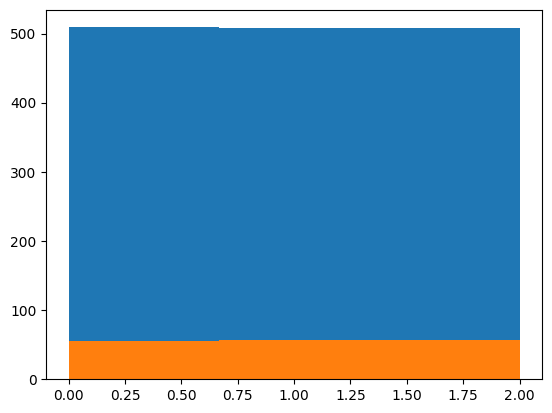

In [60]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

In [61]:
# Функция сборки и обучения классификатора на полносвязных слоях

def create_train_classifier(in_shape,      # форма входных данных модели
                            epochs=200,    # количество эпох обучения
                            batch_size=20  # размер батча
                            ):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=in_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer=Adam(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    # Обучение модели
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика точности распознавания на обучающей и проверочной выборках
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               9728      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

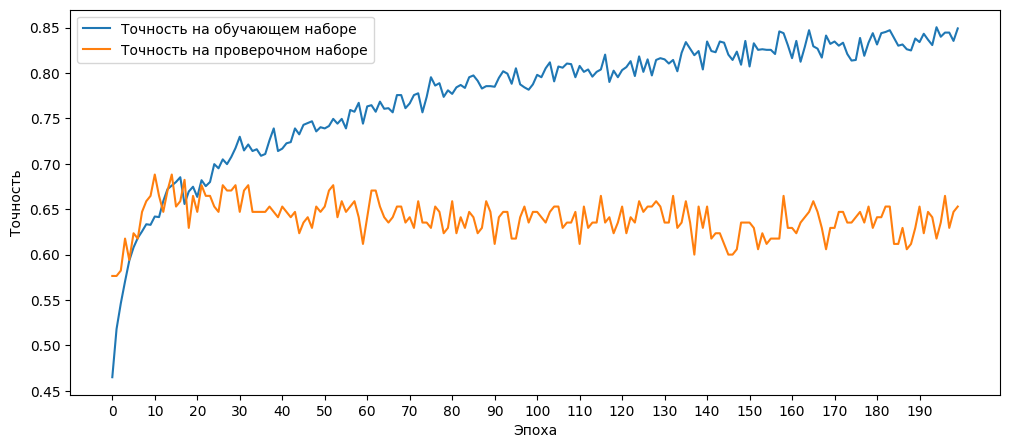

In [62]:
model = create_train_classifier(x_train.shape[1:])

In [63]:
# Сохранение/восстановление модели и выборок

model.save('/content/drive/MyDrive/Phone_calls/V2/model_data/model_audio_mean.h5')
with open('/content/drive/MyDrive/Phone_calls/V2/model_data/audio_train_val_mean.pickle', 'wb') as f:
    pickle.dump((x_train, y_train, x_val, y_val, x_scaler), f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
